In [1]:
print("hello")

hello


In [38]:
import numpy as np
import pandas  as pd 
import os  
import matplotlib.pyplot as plt 
import seaborn  as sns 
import warnings


In [6]:
from tqdm.notebook import  tqdm 
warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
print("Done") 

Done


##  loading the DataSet 

In [10]:
base_dir = '../input/utkface-new/UTKFace/'

In [16]:
#  age and gender and  ethnicity  
image_paths  = []
age_label = []
gender_lab = []

#go inside  this dir  and get each file 
for  filename in  tqdm(os.listdir(base_dir)):
    image_path =  os.path.join(base_dir ,  filename) 
    temp = filename.split('_') # in the data set the age is  included  in it 
    age =  int(temp[0])
    gender =  int(temp[1]) 
    image_paths.append(image_path)
    age_label.append(age)
    gender_lab.append(gender)
    

  0%|          | 0/23708 [00:00<?, ?it/s]

##  loaded in the list is  succeess fully 
#  conver to Data Frame 

In [19]:
df =  pd.DataFrame()
df['image'] =  image_paths 
df['age'] =  age_label
df['gender'] =  gender_lab 

df.head()

,image,age,gender
0,../input/utkface-new/UTKFace/26_0_2_2017010402...,26,0
1,../input/utkface-new/UTKFace/22_1_1_2017011223...,22,1
2,../input/utkface-new/UTKFace/21_1_3_2017010500...,21,1
3,../input/utkface-new/UTKFace/28_0_0_2017011718...,28,0
4,../input/utkface-new/UTKFace/17_1_4_2017010322...,17,1


In [20]:
# gender age  dict  

gender_dict = {0 :"Male" , 1:"Female"}


## exploretory  Data analytices 

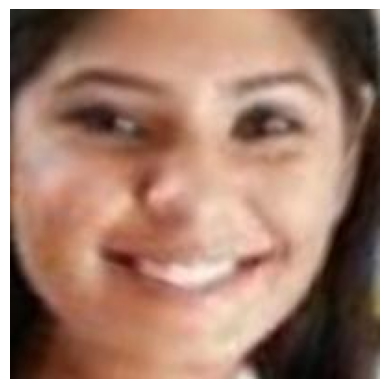

In [25]:
from PIL import  Image 
img =  Image.open(df['image'][2])
plt.axis('off')
plt.imshow(img)  

##  checking of the Data fit in it SuceessFully 

<Axes: xlabel='age', ylabel='Density'>

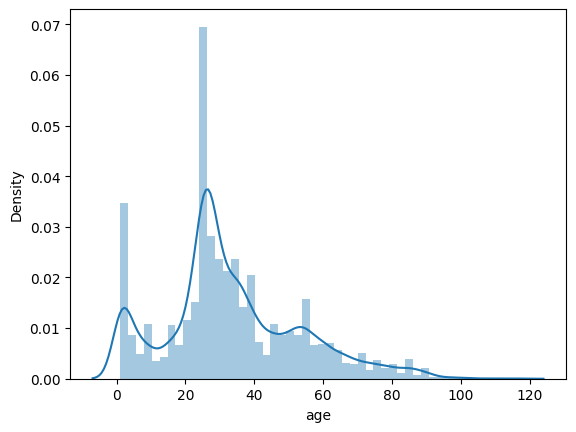

In [26]:
sns.distplot(df['age']) ##  see the age  Distribution

##  max people in the range of 20-40 

<Axes: xlabel='gender', ylabel='Density'>

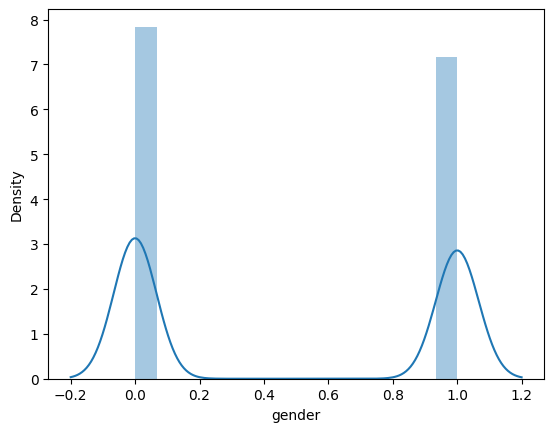

In [36]:
sns.distplot(df['gender'])

##  almost equal number of image of male and female 

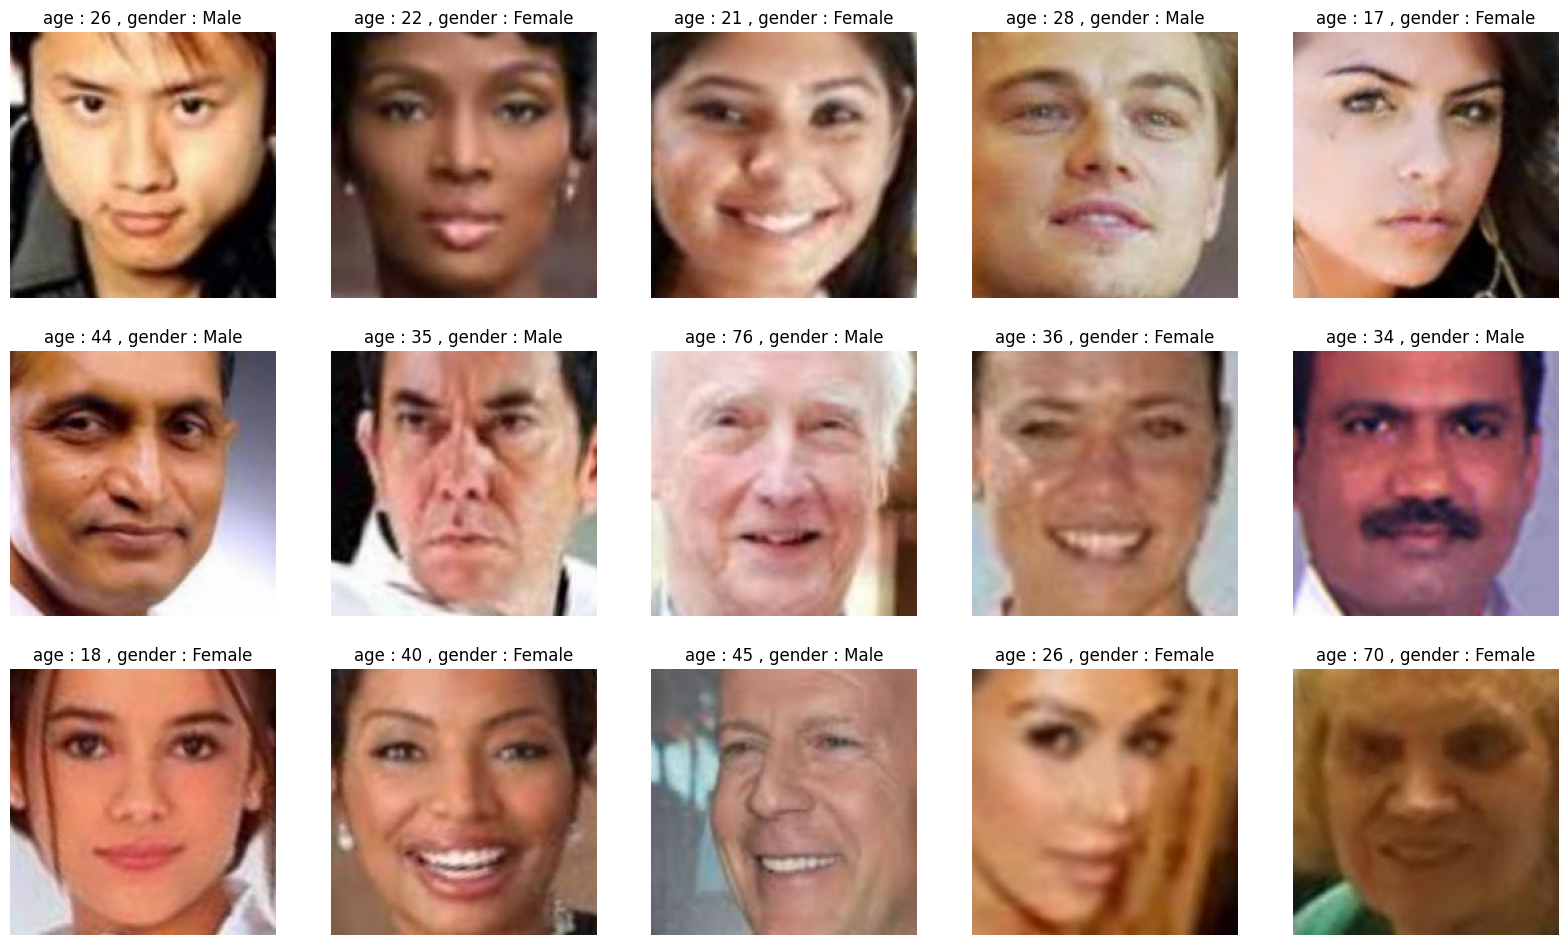

In [42]:
plt.figure(figsize=(20,20))
files =  df.iloc[0:15]

# lets see the first  25 images 
for index , file , age , gender  in files.itertuples():
    plt.subplot(5,5,index+1)
    img =  load_img(file)
    img =  np.array(img)
    plt.imshow(img)
    plt.title(f"age : {age} , gender : {gender_dict[gender]}")
    plt.axis("off") ##  ignore the axis and get only the images 
    
    
    

##  lets  do  the Feature extraction 


In [84]:

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [85]:
##  lets get the extract  images  input 
x =  extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [86]:
x.shape #  check the  shape  and  then normalising the images  
x =  x/255.0  ##  so  it is in the range of 0-2 

y_gender  =  np.array(df['gender'])
y_age =  np.array(df['age']) 
input_shape  =  (128 ,128, 1)
print("done")


done


In [89]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(x)

###  let  Creat  our model 

In [90]:
from keras.layers import BatchNormalization

inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
batch_norm_1 = BatchNormalization()(conv_1)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (batch_norm_1)

conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
batch_norm_2 = BatchNormalization()(conv_2)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (batch_norm_2)

conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
batch_norm_3 = BatchNormalization()(conv_3)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (batch_norm_3)

conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
batch_norm_4 = BatchNormalization()(conv_4)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (batch_norm_4)

flatten = Flatten() (maxp_4)

dense_1 = Dense(256, activation='relu') (flatten)
dropout_1 = Dropout(0.4) (dense_1)
output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)

dense_2 = Dense(256, activation='relu') (flatten)
dropout_2 = Dropout(0.4) (dense_2)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])


model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

In [91]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 126, 126,  │        320 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 126, 126,  │        128 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 61, 61,    │     18,496 │ max_pooling2d_28… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        256 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 28, 28,    │     73,856 │ max_pooling2d_29… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        512 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 12, 12,    │    295,168 │ max_pooling2d_30… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │      1,024 │ conv2d_33[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 6, 6, 256) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 9216)      │          0 │ max_pooling2d_31… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │  2,359,552 │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │  2,359,552 │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 256)       │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 256)       │          0 │ dense_15[0][0]  

 Total params: 5,109,378 (19.49 MB)

 Trainable params: 5,108,418 (19.49 MB)

 Non-trainable params: 960 (3.75 KB)

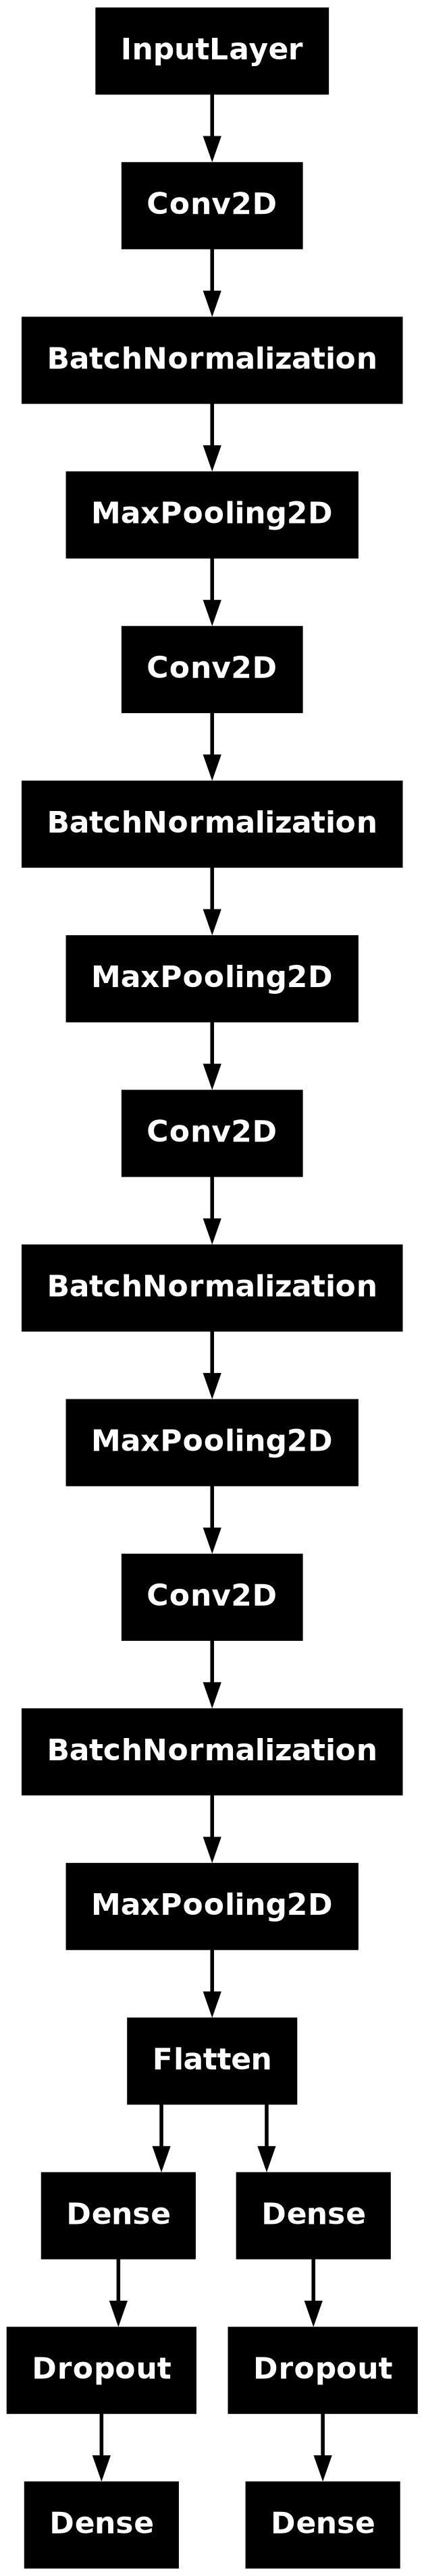

In [92]:
##  lets plot the model  using keras 

from tensorflow.keras.utils  import  plot_model 
plot_model(model)


#  here  u can  see the proper model of it input then cnn and the 2 dense (age , gender)

In [93]:
# train model   ##  it need single input x  defined above by normal  data  and 2  output it  give 
history = model.fit(x=x , y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

# we  split the data in 80 - 20  %  part  

Epoch 1/30
  8/593 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - age_out_mae: 25.6398 - gender_out_accuracy: 0.5355 - loss: 28.8651

W0000 00:00:1719307072.725634    3778 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - age_out_mae: 13.0135 - gender_out_accuracy: 0.7211 - loss: 13.9663

W0000 00:00:1719307092.487540    3781 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719307094.022219    3779 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


593/593 ━━━━━━━━━━━━━━━━━━━━ 32s 38ms/step - age_out_mae: 13.0102 - gender_out_accuracy: 0.7212 - loss: 13.9623 - val_age_out_mae: 9.2297 - val_gender_out_accuracy: 0.8450 - val_loss: 9.5776
Epoch 2/30
  7/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - age_out_mae: 8.7706 - gender_out_accuracy: 0.8698 - loss: 9.0959

W0000 00:00:1719307095.270616    3778 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


593/593 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - age_out_mae: 8.7710 - gender_out_accuracy: 0.8472 - loss: 9.1125 - val_age_out_mae: 8.9819 - val_gender_out_accuracy: 0.8370 - val_loss: 9.3381
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - age_out_mae: 7.9853 - gender_out_accuracy: 0.8626 - loss: 8.2856 - val_age_out_mae: 7.4005 - val_gender_out_accuracy: 0.8730 - val_loss: 7.6712
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - age_out_mae: 7.3980 - gender_out_accuracy: 0.8824 - loss: 7.6642 - val_age_out_mae: 6.9982 - val_gender_out_accuracy: 0.8766 - val_loss: 7.2618
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - age_out_mae: 6.9589 - gender_out_accuracy: 0.8952 - loss: 7.1977 - val_age_out_mae: 7.1119 - val_gender_out_accuracy: 0.8842 - val_loss: 7.3776
Epoch 6/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - age_out_mae: 6.7924 - gender_out_accuracy: 0.9008 - loss: 7.0205 - val_age_out_mae: 11.0599 - val_gender_out_accuracy: 0.8823 - val_loss: 11.3192
Epoch 7/3

##  model  fitting is done 


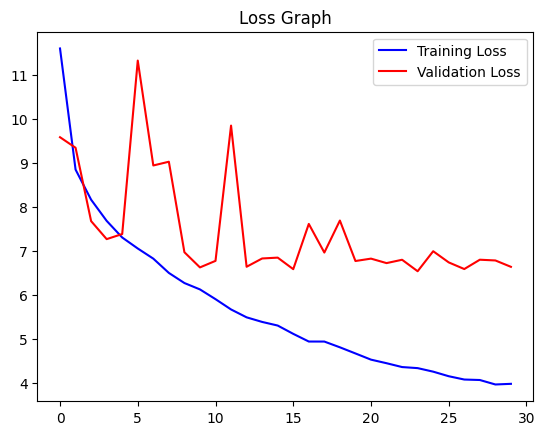

In [94]:
 ##  this show the loss accuracy  in the model for gender  
epochs = range(len(acc))

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


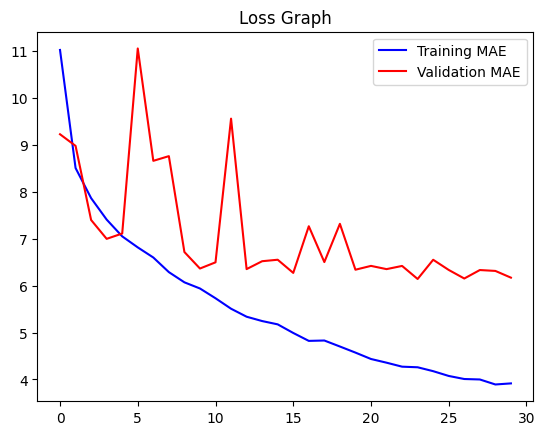

In [95]:
epochs = range(len(acc))  ##  this show the loss accuracy  in the model for age 

loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']  ##  this data taken  from  the epochs  
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

##  lets  check  our  model base on the different test 

original_gender Female
original_age 25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1.0
predict gender : Female  predict_age :  24


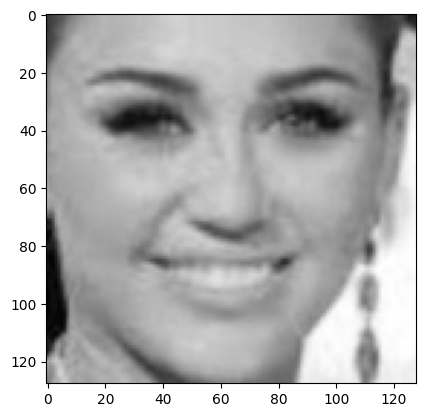

In [118]:
image_index =  180
print("original_gender" ,  gender_dict[y_gender[image_index]])
print("original_age" ,  y_age[image_index])

pred =  model.predict(x[image_index].reshape(1,128 , 128 , 1))
print(pred[0][0][0])
pred_gender =  gender_dict[round(pred[0][0][0])]  #  first one is gender  
pred_age =  round(pred[1][0][0])  ##  sec is age 

print("predict gender :" ,  pred_gender , " predict_age : " ,  pred_age)


plt.imshow(x[image_index].reshape(128 , 128) , cmap='gray')

## YES   it predicting well   for  you  prediction you  have to  run in juputer notebook  and then  check 

#  it is working fine  lets  do  for  the  your self  by webcam (apki age kay  thi)


In [113]:
import cv2 as cv  


# Initialize webcam
cap = cv.VideoCapture(0)
cap.set(3, 900)
cap.set(4, 800)
print("Starting video capture...")

my_img = None

while True:
    err, img = cap.read()
    if not err:
        print("Camera problem")
        break
        
    cv.imshow("frame", img)
    key = cv.waitKey(1)
    if key == 13:  # Press Enter to capture the image
        my_img = img
        cap.release()
        break
        
# cv.destroyAllWindows

if my_img is not None:
    gray_image = cv.cvtColor(my_img, cv.COLOR_BGR2GRAY)
    resized_image = cv.resize(gray_image, (128, 128))
    input_image = np.array(resized_image).reshape(1, 128, 128, 1)

    # Predict gender and age
    pred = model.predict(input_image)

    pred_gender = gender_dict[round(pred[0][0][0])]  # First output is gender
    pred_age = round(pred[1][0][0])  # Second output is age

    # Print predictions
    print("Predicted age:", pred_age)
    print("Predicted gender:", pred_gender)

    # Display the captured image
    plt.imshow(cv.cvtColor(my_img, cv.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    plt.title(f"Predicted Gender: {pred_gender}, Predicted Age: {pred_age}")
    plt.axis('off')
    plt.show()


##  keggle not give permission to  run the camera 

Starting video capture...
Camera problem


[ WARN:0@882.416] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@882.416] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range
